# Prevendo valores do IBOV com algoritmos de machine learning

## Iniciando a coleta e análise exporatória dos dados:

### Importando as blibliotecas que serão utilizadas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import utils

### Carregando o dataframe:

In [2]:
df = pd.read_csv('./Ibovespa.csv')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.01.2024,131.447,132.424,132.426,131.203,"9,29M","-0,74%"
1,08.01.2024,132.427,132.023,132.498,131.015,"8,50M","0,31%"
2,05.01.2024,132.023,131.218,132.635,130.579,"9,20M","0,61%"
3,04.01.2024,131.226,132.831,132.885,131.024,"8,97M","-1,21%"
4,03.01.2024,132.834,132.697,133.576,132.250,"8,70M","0,10%"


### Analisando o dataframe:

In [3]:
df.shape

(4957, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4957 non-null   object 
 1   Último    4957 non-null   float64
 2   Abertura  4957 non-null   float64
 3   Máxima    4957 non-null   float64
 4   Mínima    4957 non-null   float64
 5   Vol.      4956 non-null   object 
 6   Var%      4957 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.2+ KB


In [5]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,4957.000000,4957.000000,4957.000000,4957.000000
mean,66.905230,66.884093,67.554808,66.220636
std,28.072064,28.064641,28.260353,27.872580
min,17.604000,17.607000,18.387000,17.601000
25%,49.107000,49.102000,49.658000,48.456000
50%,60.653000,60.645000,61.299000,59.985000
75%,85.973000,85.918000,86.990000,85.197000
max,134.194000,134.194000,134.389000,133.832000


In [6]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

---
#### Observações:

*Quantidade de Entradas: 4.957 registros.*

*Intervalo Temporal: 20 anos.*

*Periodicidade dos dados: Diária.*

---
#### Colunas:

**Data:** A data da entrada do índice (tipo object, precisa ser convertido para datetime).

**Último:** O valor de fechamento do índice (float64).

**Abertura:** O valor de abertura do índice (float64).

**Máxima:** O valor máximo que o índice atingiu (float64).

**Mínima:** O valor mínimo que o índice atingiu (float64).

**Vol.:** O volume de negociações, representado como uma string que precisa de limpeza e conversão para um tipo numérico.

**Var%:** A variação percentual do índice, também como string e que precisa ser convertida para um tipo numérico.


---

### Iniciando as transformações e limpeza:

In [7]:
df['Vol.'] = df['Vol.'].apply(utils.convert_volume)
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
df['Vol.'].fillna(method='ffill', inplace=True)

In [8]:
df.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,4957,4957.000000,4957.000000,4957.000000,4957.000000,4.957000e+03,4957.000000
mean,2014-01-05 04:08:39.991930624,66.905230,66.884093,67.554808,66.220636,3.446364e+07,0.050446
min,2004-01-02 00:00:00,17.604000,17.607000,18.387000,17.601000,1.121000e+05,-14.780000
25%,2009-01-02 00:00:00,49.107000,49.102000,49.658000,48.456000,2.820000e+06,-0.840000
50%,2014-01-07 00:00:00,60.653000,60.645000,61.299000,59.985000,4.430000e+06,0.070000
75%,2019-01-14 00:00:00,85.973000,85.918000,86.990000,85.197000,1.216000e+07,0.980000
max,2024-01-09 00:00:00,134.194000,134.194000,134.389000,133.832000,9.949600e+08,14.660000
std,NaN,28.072064,28.064641,28.260353,27.872580,7.992799e+07,1.705565


In [9]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [10]:
df.head(10)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-01-09,131.447,132.424,132.426,131.203,9290000.0,-0.74
1,2024-01-08,132.427,132.023,132.498,131.015,8500000.0,0.31
2,2024-01-05,132.023,131.218,132.635,130.579,9200000.0,0.61
3,2024-01-04,131.226,132.831,132.885,131.024,8970000.0,-1.21
4,2024-01-03,132.834,132.697,133.576,132.250,8700000.0,0.10
5,2024-01-02,132.697,134.186,134.195,132.095,8440000.0,-1.11
6,2023-12-28,134.185,134.194,134.389,133.832,7810000.0,-0.01
7,2023-12-27,134.194,133.523,134.195,133.328,6170000.0,0.49
8,2023-12-26,133.533,132.753,133.645,132.753,5150000.0,0.59
9,2023-12-22,132.753,132.182,133.035,132.094,8230000.0,0.43


### Despresando os valores de Abertura, Máxima, Mínima, Volume e Variação:

In [11]:
df = df[['Data', 'Último']]
df

,Data,Último
0,2024-01-09,131.447
1,2024-01-08,132.427
2,2024-01-05,132.023
3,2024-01-04,131.226
4,2024-01-03,132.834
...,...,...
4952,2004-01-08,23.717
4953,2004-01-07,23.320
4954,2004-01-06,23.576
4955,2004-01-05,23.532


### Renomeando as colunas para facilitar o trabalho de análise:

In [12]:
df.rename(columns={'Data':'DS','Último':'Y'},inplace=True)
df.set_index('DS',inplace=True)
df.head(10)

,Y
DS,
2024-01-09,131.447
2024-01-08,132.427
2024-01-05,132.023
2024-01-04,131.226
2024-01-03,132.834
2024-01-02,132.697
2023-12-28,134.185
2023-12-27,134.194
2023-12-26,133.533


#### Visualizando os valores de fechamento e a tendência história:

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Y'], mode='lines', name='lines'))

x = np.array(range(len(df)))
y = df['Y'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

fig.add_trace(go.Scatter(x=df.index, y=line, mode='lines', name='Linha de Tendência'))

fig.update_layout(showlegend=True)
fig.show()


### Análise de série temporal (Decomposição)

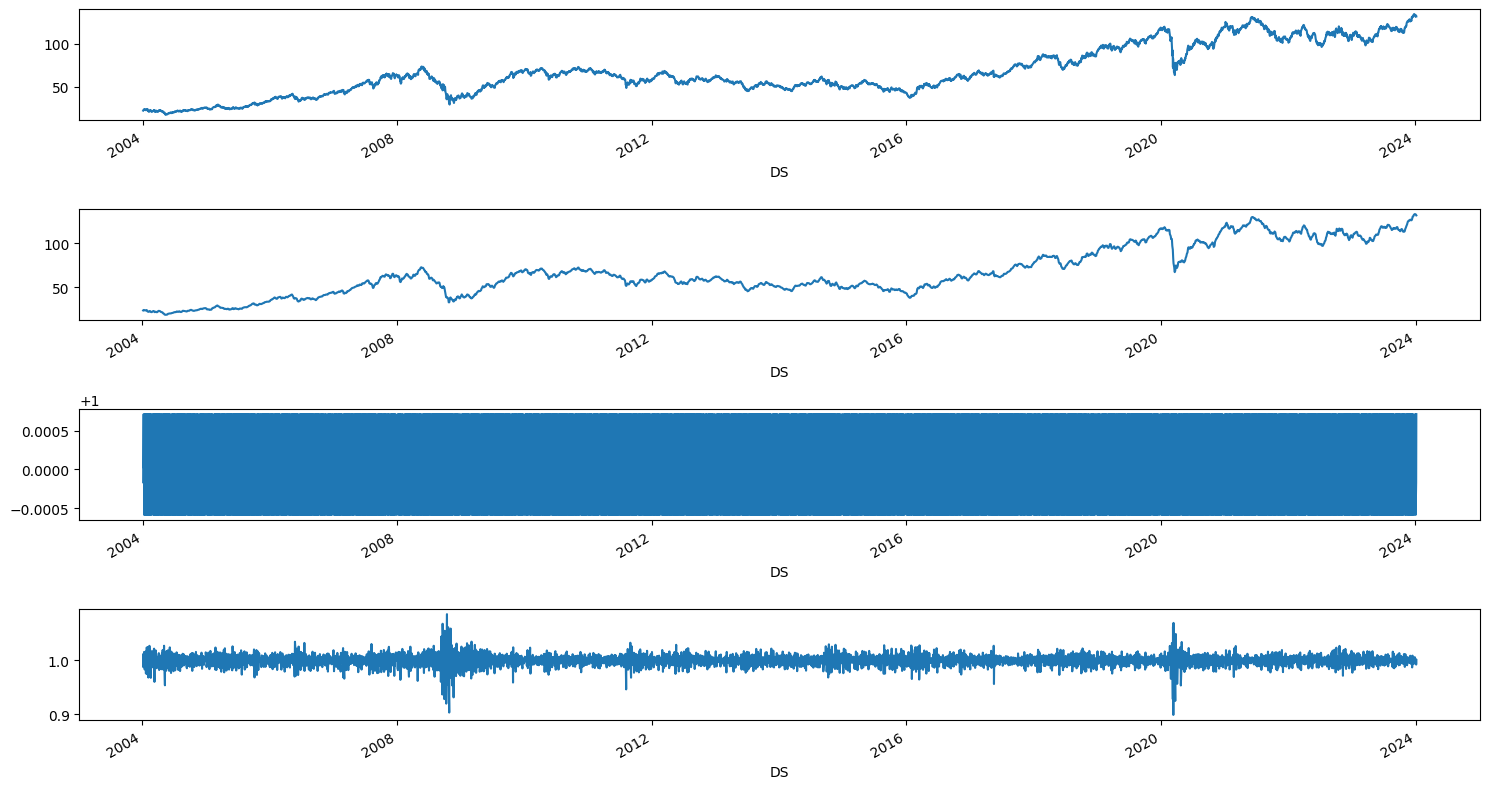

In [14]:
df_dec = df.copy()
df_dec = df_dec['Y']
seasonplot = seasonal_decompose(df_dec, model='multiplicative', period=5) # A bolsa de valores abre 5 dias por semana
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

#### Queda de 2008
A queda de 2008 está relacionada à crise financeira global desencadeada pela bolha imobiliária dos EUA, conhecida como a "crise do subprime". Os efeitos dessa crise foram sentidos em mercados financeiros ao redor do mundo, incluindo a Bovespa, que viu uma redução significativa no valor dos ativos, em linha com a aversão global ao risco e a fuga de capitais.

#### Recuperação de 2009
Em 2009, houve uma recuperação no mercado de ações, incluindo o Ibovespa, em grande parte devido às medidas de estímulo econômico adotadas por governos e bancos centrais em várias partes do mundo. No Brasil, a economia começou a mostrar sinais de melhora, e os investidores recuperaram a confiança, levando a uma recuperação do valor do índice.

#### Queda de 2015
A queda de 2015 pode ser atribuída a uma combinação de fatores, incluindo a desaceleração econômica do Brasil, a crise política interna e a redução dos preços das commodities. Estes eventos tiveram um impacto negativo sobre o mercado de ações brasileiro, resultando em uma performance menos favorável do Ibovespa.

#### Recuperação de 2016
A recuperação do Ibovespa em 2016 foi parcialmente impulsionada pela melhoria do clima político após o impeachment da presidente Dilma Rousseff e a perspectiva de reformas econômicas propostas pelo novo governo. Além disso, a recuperação dos preços das commodities e a melhora do cenário econômico global ajudaram a impulsionar o mercado de ações.

#### Queda de 2020
A queda de 2020 foi desencadeada pela pandemia de COVID-19, que causou um choque sem precedentes nas economias globais e nacionais. O Ibovespa, assim como outros índices ao redor do mundo, sofreu quedas acentuadas devido às incertezas econômicas e ao impacto das medidas de confinamento na atividade econômica.

#### Recuperação de 2020
Surpreendentemente, ainda em 2020, o Ibovespa e outros mercados começaram a se recuperar rapidamente após as quedas iniciais. As respostas políticas, incluindo estímulos fiscais e monetários significativos e o progresso no desenvolvimento de vacinas, ajudaram a restaurar a confiança dos investidores e a promover uma recuperação nos preços das ações.

### Analisando a Volatilidade:

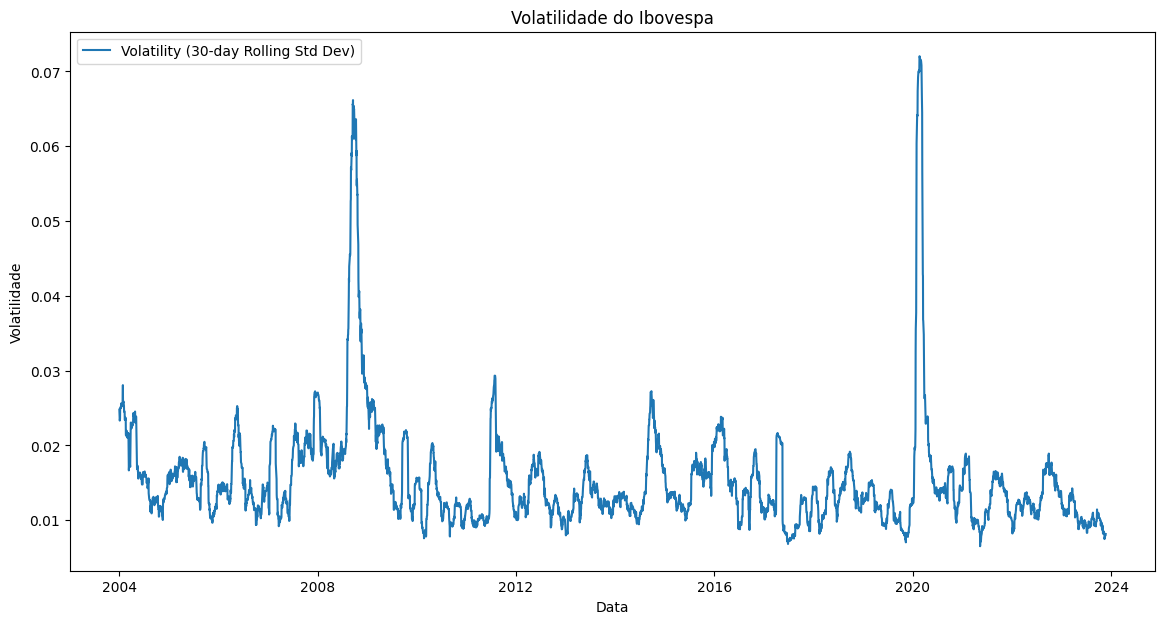

In [15]:
df_vol = df.copy()
df_vol['DailyReturns'] = df_vol['Y'].pct_change()

df_vol['Volatility'] = df_vol['DailyReturns'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(df_vol['Volatility'], label='Volatility (30-day Rolling Std Dev)')
plt.title('Volatilidade do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Volatilidade')
plt.legend()
plt.show()


### Volatilidade

Períodos de alta volatilidade podem ser observados no gráfico, que muitas vezes correspondem a eventos econômicos ou políticos significativos. Por exemplo, picos de volatilidade podem ​​estar associados a crises financeiras, mudanças políticas, ou outros eventos que causam incerteza no mercado.

### Analisando a correlação dos dados:

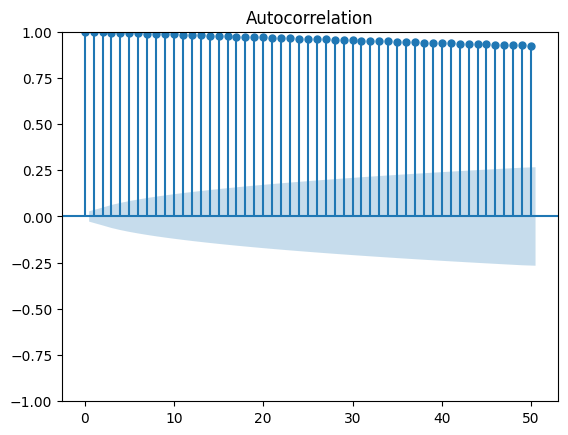

In [16]:
df_corr = df.copy()
df_corr = df_corr['Y']
df_corr = df_corr.to_frame()
sm.graphics.tsa.plot_acf(df_corr, lags=50, alpha=0.05)
plt.show()

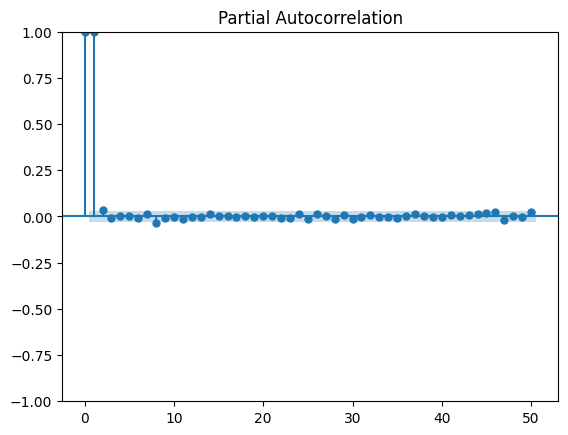

In [17]:
sm.graphics.tsa.plot_pacf(df_corr, lags=50, alpha=0.05)
plt.show()

#### Autocorrelação

Ambos os gráficos mostram que existe autocorrelação nos dados do Ibovespa. Isso é esperado em séries temporais financeiras, onde os preços podem ser influenciados por seus próprios valores históricos.

### Analisando a Estacionaridade da Série Temporal:

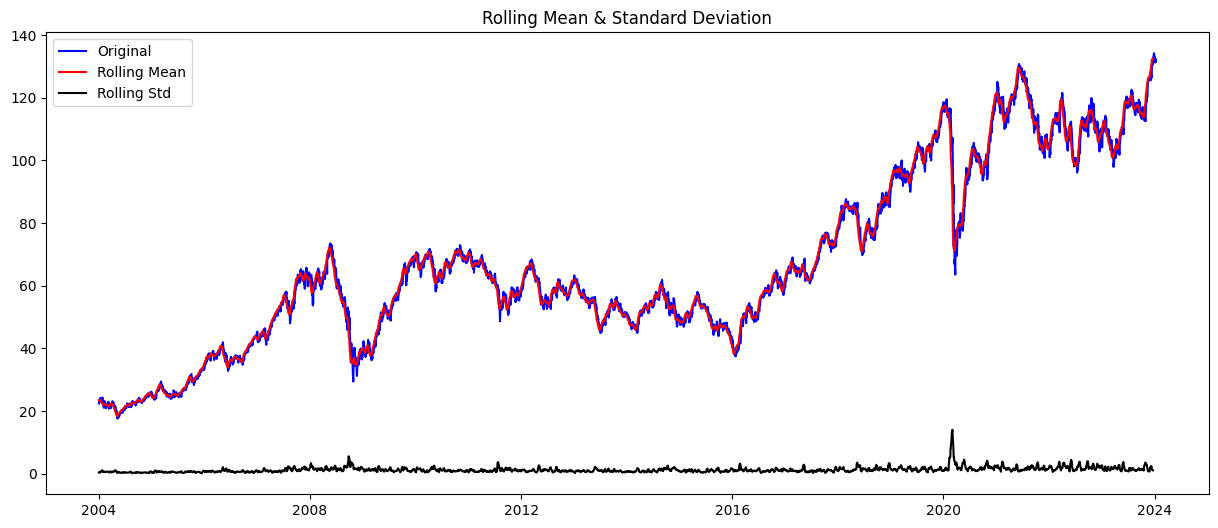

Results of Dickey Fuller Test:
Test Statistic                   -1.926825
p-value                           0.319549
#Lags Used                       11.000000
Number of Observations Used    4945.000000
Critical Value (1%)              -3.431673
Critical Value (5%)              -2.862125
Critical Value (10%)             -2.567081
dtype: float64
Conclusão: A série NÂO é Estacionária.


In [18]:
utils.test_stationarity(df)

#### Conclusão:

**A série NÃO é Estacionária.**

## Analisando a correlação do IBOV com o valor do Dólar e indice S&P 500

In [19]:
df_usd = pd.read_csv('./USD.csv', sep=';', decimal=',', thousands='.', na_values='', parse_dates=['Data'], dayfirst=True)
df_usd.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol','Var%'], axis=1, inplace=True)
df_usd.rename(columns={'Data':'DS','Último':'Y' },inplace=True)
df_usd.set_index('DS',inplace=True)
df_usd.head(10)

,Y
DS,
2024-01-09,4.9038
2024-01-08,4.8700
2024-01-05,4.8743
2024-01-04,4.8968
2024-01-03,4.9198
2024-01-02,4.9235
2024-01-01,4.8526
2023-12-28,4.8521
2023-12-27,4.8267


In [20]:
df_usd.isna().sum()

Y    0
dtype: int64

In [21]:
df_500 = pd.read_csv('./SP500.csv', sep=';', decimal=',', thousands='.', na_values='', parse_dates=['Data'], dayfirst=True)
df_500.drop(columns=['Abertura', 'Máxima', 'Mínima','Var%'], axis=1, inplace=True)
df_500.rename(columns={'Data':'DS','Último':'Y' },inplace=True)
df_500.set_index('DS',inplace=True)
df_500.head(10)

,Y
DS,
2024-01-09,4756.50
2024-01-08,4763.54
2024-01-05,4697.24
2024-01-04,4688.68
2024-01-03,4704.81
2024-01-02,4742.83
2023-12-29,4769.83
2023-12-28,4783.35
2023-12-27,4781.58


In [22]:
df_500.isna().sum()

Y    0
dtype: int64

In [23]:
df_join = df.merge(df_usd, on='DS', suffixes=('', '_USD')).merge(df_500, on='DS', suffixes=('', '_500'))
df_join.head(10)

,Y,Y_USD,Y_500
DS,,,
2024-01-09,131.447,4.9038,4756.50
2024-01-08,132.427,4.8700,4763.54
2024-01-05,132.023,4.8743,4697.24
2024-01-04,131.226,4.8968,4688.68
2024-01-03,132.834,4.9198,4704.81
2024-01-02,132.697,4.9235,4742.83
2023-12-28,134.185,4.8521,4783.35
2023-12-27,134.194,4.8267,4781.58
2023-12-26,133.533,4.8140,4774.75


In [24]:
df_join.isna().sum()

Y        0
Y_USD    0
Y_500    0
dtype: int64

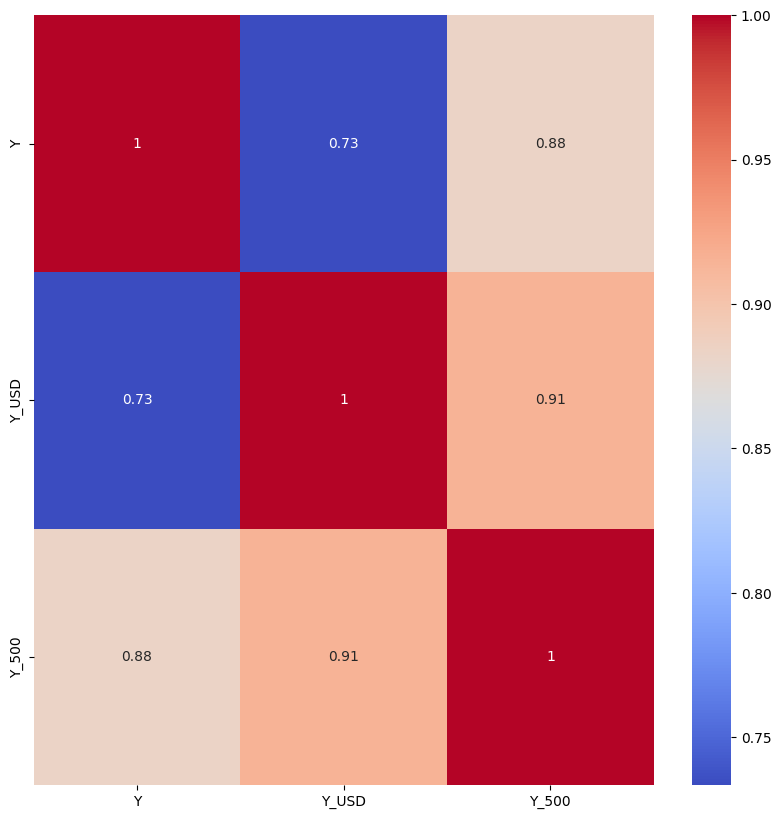

In [25]:
df_join_corr = df_join.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(df_join_corr, annot=True, cmap='coolwarm')
plt.show()

#### Correlação entre Y (Ibovespa) e y_500 (S&P 500):

**Correlação de 0.88:** Uma correlação forte e positiva. Isso significa que, em geral, quando o S&P 500 sobe, o Ibovespa também tende a subir. Isso pode ser explicado pelo fato de que ambos os índices são influenciados por fatores econômicos globais e pelo apetite dos investidores por risco.

#### Correlação entre Y (Ibovespa) e y_usd (Valor do dólar):

**Correlação de 0.73:** Uma correlação positiva significativa sugere que um aumento no valor do dólar está associado a um aumento no índice Bovespa. Essa relação pode parecer contra-intuitiva à primeira vista, pois muitas vezes esperamos que um fortalecimento do dólar possa afetar negativamente os mercados emergentes. No entanto, esta correlação pode refletir períodos em que um dólar mais forte coincide com um ambiente de maior liquidez global e apetite por ativos de maior risco, incluindo ações em mercados emergentes como o Brasil.

#### Correlação entre y_500 (S&P 500) e y_usd (Valor do dólar):

**Correlação de 0.91:** Esta é a correlação mais forte no conjunto de dados, indicando uma relação muito próxima entre o índice S&P 500 e o valor do dólar. Isso pode refletir o status do dólar como moeda de reserva mundial e o impacto das políticas econômicas dos EUA nos mercados globais de ações. Um dólar forte pode ser um sinal de confiança na economia dos EUA, o que, por sua vez, pode impulsionar o mercado de ações dos EUA e ter um efeito de transbordamento em outros mercados acionários globais.

## Por que escolhi trabalhar com dados pós-2020?

1. **Eventos Extraordinários**: Os períodos anteriores a 2021 foram marcados por eventos atípicos e choques externos, como a crise financeira de 2008, a crise política brasileira de 2015 e a pandemia de COVID-19 em 2020. Esses eventos podem ser considerados outliers em termos de modelagem preditiva, pois são influenciados por fatores que não são recorrentes ou que não refletem as condições normais de mercado.

2. **Mudanças Estruturais**: Cada um desses eventos levou a mudanças estruturais nos mercados financeiros e na economia como um todo. Isso inclui mudanças nas políticas econômicas, medidas de estímulo e a dinâmica do mercado em resposta à crise. Ao começar o conjunto de dados de 2021, é possível focar em um período que representa um "novo normal" após a acomodação dessas mudanças.

3. **Estabilidade e Previsibilidade**: Os modelos preditivos se beneficiam de estabilidade nos dados para capturar tendências e padrões subjacentes. Iniciar o conjunto de dados pós-2020 pode proporcionar um ambiente de mercado mais estável e previsível, eliminando a volatilidade extrema e as condições de mercado atípicas causadas por crises.

4. **Relevância Atual**: Utilizar dados mais recentes garante que o modelo seja treinado com informações que são mais relevantes para as condições atuais do mercado. Isso é particularmente importante em mercados financeiros, onde as condições econômicas e as dinâmicas de mercado podem mudar rapidamente.

5. **Redução de Viés de Eventos Passados**: Excluir dados de períodos marcados por crises graves pode ajudar a reduzir o viés que esses eventos podem introduzir no modelo, garantindo que o modelo não sobrevalorize a probabilidade de ocorrência de eventos semelhantes no futuro.